# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data/retail_train.csv')
item_features = pd.read_csv('raw_data/product.csv')
user_features = pd.read_csv('raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1044078, 871756, 883932, 925862]

In [6]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [7]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 844179, 907099, 1075175]

In [8]:
recommender.get_similar_users_recommendation(2375, N=5)

[963686, 1101502, 820612, 9392700, 983665]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [9]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [10]:
from tqdm import tqdm

In [11]:
N=50
K=10
recall_result = dict()
except_ids = []

for user_id in tqdm(result_lvl_1['user_id'].values):

    bought_list = result_lvl_1[result_lvl_1['user_id']==1]['actual'].values[0]
    
    try:
        als_rec = recommender.get_als_recommendations(user_id, N=N)
        own_rec = recommender.get_own_recommendations(user_id, N=N)
        sim_item_rec = recommender.get_similar_items_recommendation(user_id, N=N)
        sim_user_rec = recommender.get_similar_users_recommendation(user_id, N=N)
        
        
        recall_als = recall_at_k(als_rec, bought_list, k=K)
        recall_result["recall_als"] = np.append(recall_result["recall_als"], recall_als) \
        if "recall_als" in recall_result.keys() else np.array([recall_als])

        recall_own = recall_at_k(own_rec, bought_list, k=K)
        recall_result["recall_own"] = np.append(recall_result["recall_own"], recall_own) \
        if "recall_own" in recall_result.keys() else np.array([recall_own])

        recall_sim_items = recall_at_k(sim_item_rec, bought_list, k=K)
        recall_result["recall_sim_items"] = np.append(recall_result["recall_sim_items"], recall_sim_items) \
        if "recall_sim_items" in recall_result.keys() else np.array([recall_sim_items])

        recall_sim_users = recall_at_k(sim_user_rec, bought_list, k=K)
        recall_result["recall_sim_users"] = np.append(recall_result["recall_sim_users"], recall_sim_users) \
        if "recall_sim_users" in recall_result.keys() else np.array([recall_sim_users])
            
    except Exception:
        except_ids.append(user_id)

100%|██████████████████████████████████████████████████████████████████████████████| 2154/2154 [16:09<00:00,  2.22it/s]


In [12]:
print("Количество пользователей без рекомендаций:", len(except_ids))
for key in recall_result.keys():
    print(f"{key}: {np.mean(recall_result[key]):>{35-len(key)}.7f}")

Количество пользователей без рекомендаций: 202
recall_als:                 0.0016027
recall_own:                 0.0007285
recall_sim_items:           0.0016309
recall_sim_users:           0.0006533


In [13]:
recall_plt = dict()
except_ids = np.array([0, 0])
K_values = (20, 50, 100, 200, 500)
recall_values = []

for k in K_values:

    for user_id in tqdm(result_lvl_1['user_id'].values):

        bought_list = result_lvl_1[result_lvl_1['user_id']==1]['actual'].values[0]

        try:
            als_rec = recommender.get_als_recommendations(user_id, N=k)

            recall_als = recall_at_k(als_rec, bought_list, k=k)
            recall_plt[k] = np.append(recall_plt[k], recall_als) if k in recall_plt.keys() else np.array([recall_als])

        except Exception:
            except_ids = np.vstack((except_ids, np.array([k, user_id])))
    
    recall_values.append(np.mean(recall_plt[k]))

100%|██████████████████████████████████████████████████████████████████████████████| 2154/2154 [00:40<00:00, 53.46it/s]


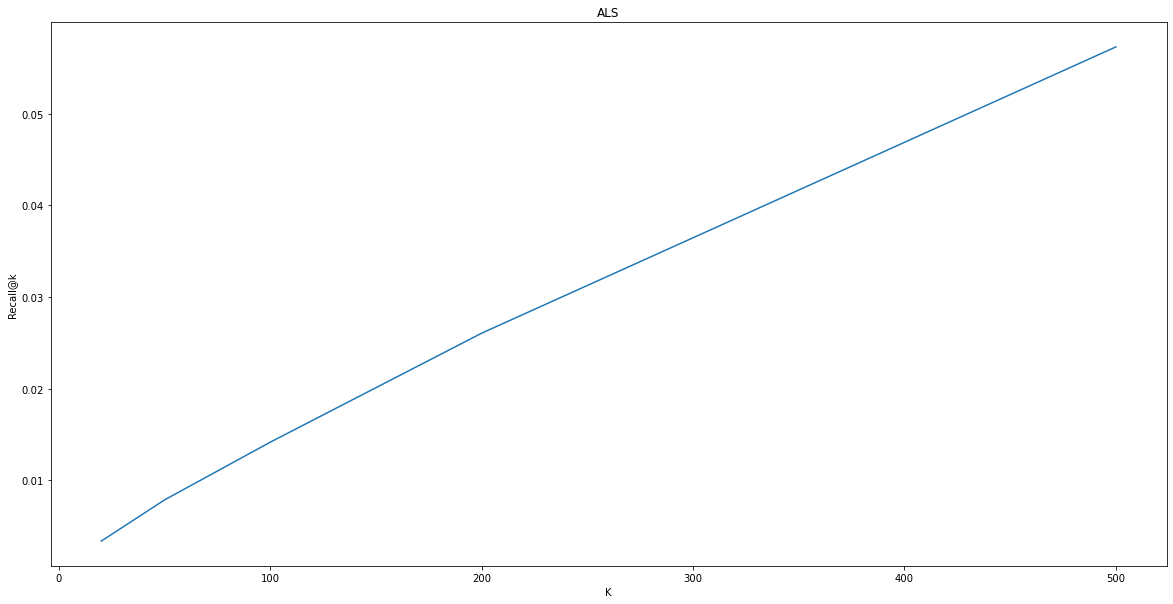

In [14]:
plt.figure(figsize=(20,10))

plt.plot(K_values, recall_values)
plt.xlabel("K")
plt.ylabel("Recall@k")
plt.title("ALS")
plt.show()

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [15]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [16]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

In [17]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [18]:
targets_lvl_2.head()

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0
2,2070,879194,0.0
3,2070,948640,0.0
4,2070,928263,0.0


In [19]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [20]:
user_features["hh_comp_desc"].unique()

array(['2 Adults No Kids', '2 Adults Kids', 'Single Female', 'Unknown',
       'Single Male', '1 Adult Kids'], dtype=object)

In [21]:
dict_kids = {'2 Adults No Kids': 0, '2 Adults Kids': 1, 'Single Female': 0, 'Unknown': 0, 'Single Male': 0, '1 Adult Kids': 1}

user_features["have_kids"] = user_features["hh_comp_desc"].replace(dict_kids)

In [22]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,have_kids
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,0
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,0
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,1
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,1
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,0


In [23]:
item_features

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ
...,...,...,...,...,...,...,...
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,
92349,18293439,6393,DRUG GM,National,BOOKSTORE,CHILDRENS LOW END,
92350,18293696,6406,DRUG GM,National,BOOKSTORE,PAPERBACK BEST SELLER,
92351,18294080,6442,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,


In [24]:
print(f"Доля расходуемых товаров: {len(np.where(item_features['curr_size_of_product'] == ' ')[0])/item_features.shape[0]}")

Доля расходуемых товаров: 0.33141316470499066


In [25]:
item_features["expendable"] = np.where(item_features["curr_size_of_product"] == " ", 0, 1) 

In [26]:
item_features

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,expendable
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,1
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,0
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,1
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,1
...,...,...,...,...,...,...,...,...
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,,0
92349,18293439,6393,DRUG GM,National,BOOKSTORE,CHILDRENS LOW END,,0
92350,18293696,6406,DRUG GM,National,BOOKSTORE,PAPERBACK BEST SELLER,,0
92351,18294080,6442,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,,0


In [27]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [28]:
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,expendable,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,have_kids
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.0
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,1,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.0
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,1,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.0
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,1,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.0
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,1,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.0


In [29]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [30]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'expendable',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'have_kids']

In [31]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

LGBMClassifier(categorical_column=['manufacturer', 'department', 'brand',
                                   'commodity_desc', 'sub_commodity_desc',
                                   'curr_size_of_product', 'expendable',
                                   'age_desc', 'marital_status_code',
                                   'income_desc', 'homeowner_desc',
                                   'hh_comp_desc', 'household_size_desc',
                                   'kid_category_desc', 'have_kids'],
               max_depth=7, objective='binary')

In [32]:
train_preds = lgb.predict_proba(X_train)[:, 1]
train_preds

array([0.09924094, 0.03171835, 0.05987653, ..., 0.16497883, 0.23844885,
       0.14128435])